In [1]:
import numpy as np
import pandas as pd
from opt_utils import *
from grad_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

### Download and Load the Raw Races Dataset

In [2]:
url = "http://personal.psu.edu/drh20/code/btmatlab/nascar2002.txt"
races_trimmed = pd.read_table(url, sep=" ")

### Create the Complete Dataset

- Most drivers do not race all of the races, 
- We need to create a dataset with every combination of all drivers/ races so that we can take pairwise differences consistently

In [3]:
# Create a cartesian product of unique drivers and races to get every combination
unq_drivers = sorted(races_trimmed["DriverID"].unique())
unq_drivers = [x for x in unq_drivers if str(x) != 'nan']
unq_races = sorted(races_trimmed["Race"].unique())
unq_races = [x for x in unq_races if str(x) != 'nan']

# Get a dataframe 
unq_drivers_df = pd.DataFrame(unq_drivers, columns=["DriverID"])
unq_races_df = pd.DataFrame(unq_races, columns=["Race"])

# Let's cross join the columns to get all unique combinations of drivers and races
all_driver_race_combs = unq_drivers_df.assign(foo=1).merge(unq_races_df.assign(foo=1)).drop('foo', 1)
all_driver_race_combs = all_driver_race_combs.sort_values(by=['Race', 'DriverID'])
all_driver_race_mg = pd.merge(all_driver_race_combs, races_trimmed,  how='left', 
                              left_on=['DriverID','Race'], right_on = ['DriverID','Race'])

### For a single race calculate the pairwise differences

In [4]:
def pawise_ind(val):
    if np.isnan(val):
        out = val
    else:
        out = (val < 0) * 1
    return out

def difference_matrix(a):
    """ Get the pairwise differences in all quantities in a 1D-numpy array
    Source: https://stackoverflow.com/questions/22863547/numpy-compute-all-possible-differences-in-an-array-at-fixed-distance"""
    x = np.reshape(a, (len(a), 1))
    return x - x.T

def get_single_race_pwise(race_num, src_dat):
    """Get all pairwise race comparisons for a single race"""
    
    race_res = all_driver_race_mg[all_driver_race_mg["Race"] == race_num]
    race_res = race_res.sort_values(by=['DriverID'])
    race_res_val = race_res.values[:, 2]
    
    vpawise_ind = np.vectorize(pawise_ind)
    pwise_diff = difference_matrix(race_res_val)
    #pwise_diff = vpawise_ind(pwise_diff)
    
    return pwise_diff

def get_all_pwise_comb(src_dat):
    unq_races = sorted(src_dat["Race"].unique())
    all_pwise_races = [get_single_race_pwise(race_num=race, src_dat=src_dat) for race in unq_races]
    return np.dstack(all_pwise_races)

## Get pairwise differences for all Drivers for a single race

In [5]:
race_16_diffs = get_single_race_pwise(race_num=16.0, src_dat=all_driver_race_mg)
race_16_diffs.shape

(83, 83)

## Get pairwise differences for all competitors and all races

In [6]:
all_pwise = get_all_pwise_comb(src_dat=all_driver_race_mg)
all_pwise.shape

(83, 83, 36)

In [7]:
all_pwise[1]

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [-21.,   2., -35., ...,   1.,   1.,  -3.],
       ...,
       [ nan,  nan,  nan, ...,  nan, -13.,  nan],
       [-32.,   7.,   3., ...,  25.,  22., -11.],
       [ 10.,  -2., -13., ...,  -1.,  11.,  -5.]])

In [8]:
all_pwise.shape

(83, 83, 36)

In [9]:
game_matrix_list = []
for i in range(all_pwise.shape[2]):
    pwise_diff = all_pwise[:,:,i]
    pwise_diff[pwise_diff <= 0] = 1
    pwise_diff[pwise_diff < 0] = 0
    pwise_diff[np.isnan(pwise_diff)] = 0
    game_matrix_list.append(pwise_diff)
game_matrix_list = np.array(game_matrix_list)

c:\python\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less_equal
  after removing the cwd from sys.path.
c:\python\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


In [10]:
game_matrix_list.shape

(36, 83, 83)

## Fit the model with squared l2-penalty

### Fit with small penalty

In [10]:
# optimization parameters
l_penalty = 20
max_iter = 1000
ths = 1e-12
step_size = 0.03

# backtracking parameters
step_init = 0.1
max_back = 100
a = 0.2
b = 0.5

In [19]:
objective_nt_l2sq, beta_nt_l2sq = newton_l2_sq(data = game_matrix_list,l_penalty = 20,
    max_iter = 1000,
    ths = 1e-12,
    step_init = 1,
    max_back = 100,
    a = 0.2,
    b = 0.5,
    verbose = True)

initial objective value: 351878.245653
1-th Newton, objective value: 184817.840790
2-th Newton, objective value: 171593.462295
3-th Newton, objective value: 170540.967313
4-th Newton, objective value: 170522.448279
5-th Newton, objective value: 170522.425876
6-th Newton, objective value: 170522.425876
7-th Newton, objective value: 170522.425876
Converged!


In [20]:
T, N = game_matrix_list.shape[0:2]
beta = beta_nt_l2sq.reshape((T,N))

# ascending order
rank = np.argsort(-beta[-1,])

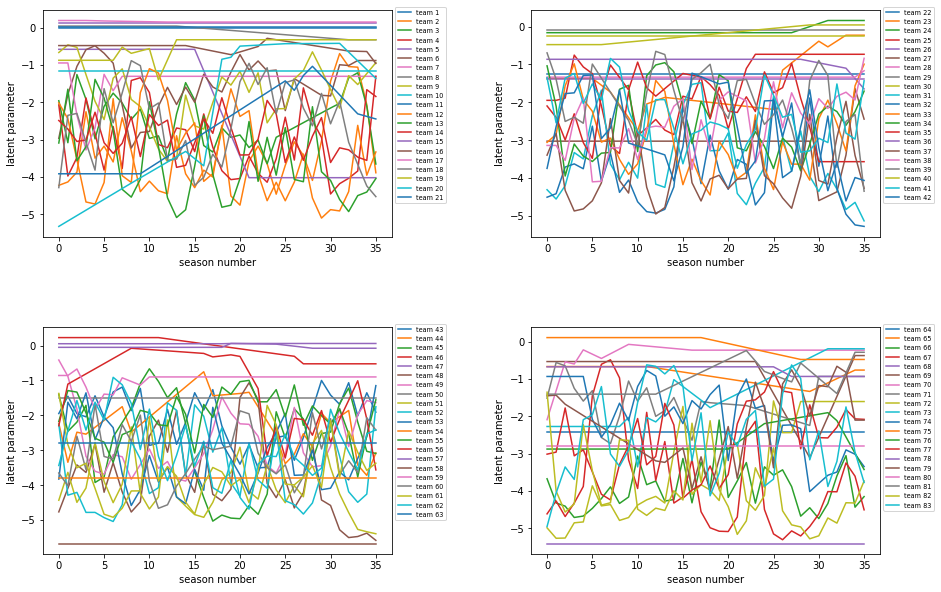

In [21]:
n_group = 4
group_id = np.array_split(range(N), n_group)
fig = plt.figure(figsize = (15,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for g in range(n_group):
    ax = fig.add_subplot(2, 2, g + 1)
    for i in group_id[g]:
        ax.plot(beta[:,i], label="team %d"%(i + 1))
    plt.xlabel("season number")
    plt.ylabel("latent parameter")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1.03, 1, 0),prop={'size': 6.5},ncol = 1)


### Fit with large penalty

### Newton

In [16]:
objective_nt_l2sq, beta_nt_l2sq = newton_l2_sq(data = game_matrix_list,l_penalty = 200,
    max_iter = 1000,
    ths = 1e-12,
    step_init = 1,
    max_back = 100,
    a = 0.2,
    b = 0.5,
    verbose = True)

initial objective value: 351878.245653
1-th Newton, objective value: 231368.343357
2-th Newton, objective value: 224645.572981
3-th Newton, objective value: 224279.641909
4-th Newton, objective value: 224273.855933
5-th Newton, objective value: 224273.848497
6-th Newton, objective value: 224273.848496
7-th Newton, objective value: 224273.848496
Converged!


In [17]:
T, N = game_matrix_list.shape[0:2]
beta = beta_nt_l2sq.reshape((T,N))

# ascending order
rank = np.argsort(-beta[-1,])

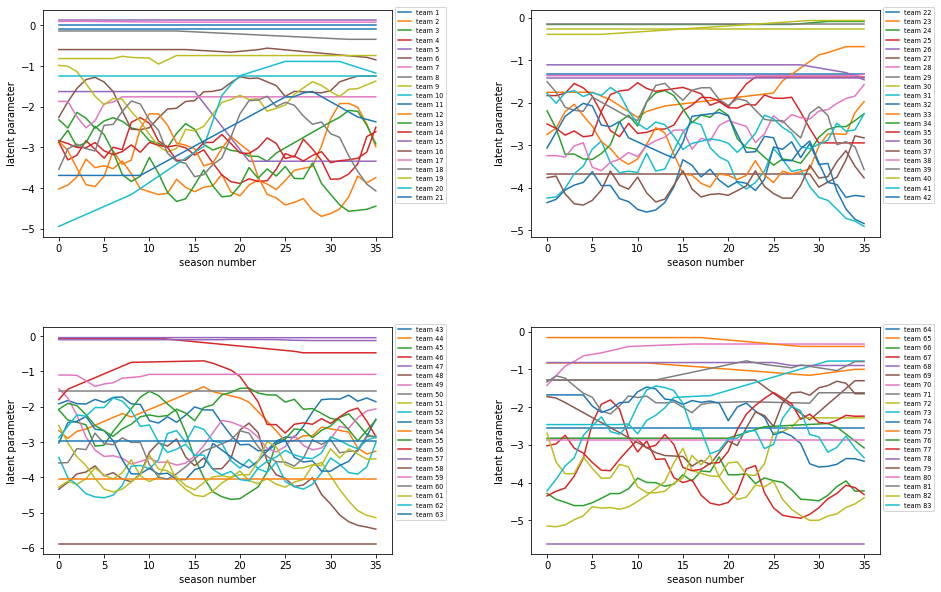

In [18]:
n_group = 4
group_id = np.array_split(range(N), n_group)
fig = plt.figure(figsize = (15,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for g in range(n_group):
    ax = fig.add_subplot(2, 2, g + 1)
    for i in group_id[g]:
        ax.plot(beta[:,i], label="team %d"%(i + 1))
    plt.xlabel("season number")
    plt.ylabel("latent parameter")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1.03, 1, 0),prop={'size': 6.5},ncol = 1)


## L1 penalty

In [22]:
from opt_utils import *
from grad_utils import *
from numpy.linalg import solve

In [24]:
objective_admm_l1, objective_admm_b_l1, beta_admm_l1 = admm_l1(data = game_matrix_list,l_penalty = 20,
    max_iter = 1000,
    ths = 1e-12,
    eta = 500,
    step_init = 1,
    max_back = 100,
    a = 0.02,
    b = 0.3,
    verbose = True,
    return_b_obj = True)

initial objective value: 351878.245653
1-th ADMM, objective value: 214017.043755
2-th ADMM, objective value: 201494.452295
3-th ADMM, objective value: 191618.358663
4-th ADMM, objective value: 185056.041436
5-th ADMM, objective value: 180299.215782
6-th ADMM, objective value: 176707.382409
7-th ADMM, objective value: 173910.723452
8-th ADMM, objective value: 171679.813409
9-th ADMM, objective value: 169875.183364
10-th ADMM, objective value: 168392.199931
11-th ADMM, objective value: 167157.340637
12-th ADMM, objective value: 166119.182670
13-th ADMM, objective value: 165239.863312
14-th ADMM, objective value: 164487.367757
15-th ADMM, objective value: 163839.733878
16-th ADMM, objective value: 163279.092866
17-th ADMM, objective value: 162791.668501
18-th ADMM, objective value: 162365.475570
19-th ADMM, objective value: 161993.263247
20-th ADMM, objective value: 161664.804770
21-th ADMM, objective value: 161375.959705
22-th ADMM, objective value: 161120.060628
23-th ADMM, objective va

189-th ADMM, objective value: 158783.185689
190-th ADMM, objective value: 158783.159143
191-th ADMM, objective value: 158783.133283
192-th ADMM, objective value: 158783.108091
193-th ADMM, objective value: 158783.083547
194-th ADMM, objective value: 158783.059636
195-th ADMM, objective value: 158783.036338
196-th ADMM, objective value: 158783.013634
197-th ADMM, objective value: 158782.991511
198-th ADMM, objective value: 158782.969947
199-th ADMM, objective value: 158782.948932
200-th ADMM, objective value: 158782.928449
201-th ADMM, objective value: 158782.908482
202-th ADMM, objective value: 158782.889022
203-th ADMM, objective value: 158782.870048
204-th ADMM, objective value: 158782.851550
205-th ADMM, objective value: 158782.833514
206-th ADMM, objective value: 158782.815930
207-th ADMM, objective value: 158782.798787
208-th ADMM, objective value: 158782.782068
209-th ADMM, objective value: 158782.765764
210-th ADMM, objective value: 158782.749866
211-th ADMM, objective value: 15

376-th ADMM, objective value: 158782.121650
377-th ADMM, objective value: 158782.121385
378-th ADMM, objective value: 158782.121127
379-th ADMM, objective value: 158782.120875
380-th ADMM, objective value: 158782.120629
381-th ADMM, objective value: 158782.120389
382-th ADMM, objective value: 158782.120154
383-th ADMM, objective value: 158782.119925
384-th ADMM, objective value: 158782.119702
385-th ADMM, objective value: 158782.119484
386-th ADMM, objective value: 158782.119271
387-th ADMM, objective value: 158782.119063
388-th ADMM, objective value: 158782.118860
389-th ADMM, objective value: 158782.118662
390-th ADMM, objective value: 158782.118468
391-th ADMM, objective value: 158782.118279
392-th ADMM, objective value: 158782.118095
393-th ADMM, objective value: 158782.117915
394-th ADMM, objective value: 158782.117739
395-th ADMM, objective value: 158782.117568
396-th ADMM, objective value: 158782.117400
397-th ADMM, objective value: 158782.117237
398-th ADMM, objective value: 15

563-th ADMM, objective value: 158782.110567
564-th ADMM, objective value: 158782.110563
565-th ADMM, objective value: 158782.110560
566-th ADMM, objective value: 158782.110557
567-th ADMM, objective value: 158782.110554
568-th ADMM, objective value: 158782.110551
569-th ADMM, objective value: 158782.110548
570-th ADMM, objective value: 158782.110545
571-th ADMM, objective value: 158782.110542
572-th ADMM, objective value: 158782.110539
573-th ADMM, objective value: 158782.110537
574-th ADMM, objective value: 158782.110534
575-th ADMM, objective value: 158782.110532
576-th ADMM, objective value: 158782.110529
577-th ADMM, objective value: 158782.110527
578-th ADMM, objective value: 158782.110524
579-th ADMM, objective value: 158782.110522
580-th ADMM, objective value: 158782.110520
581-th ADMM, objective value: 158782.110517
582-th ADMM, objective value: 158782.110515
583-th ADMM, objective value: 158782.110513
584-th ADMM, objective value: 158782.110511
585-th ADMM, objective value: 15

In [27]:
T, N = game_matrix_list.shape[0:2]
beta = beta_admm_l1.reshape((T,N))

# ascending order
rank = np.argsort(-beta[-1,])

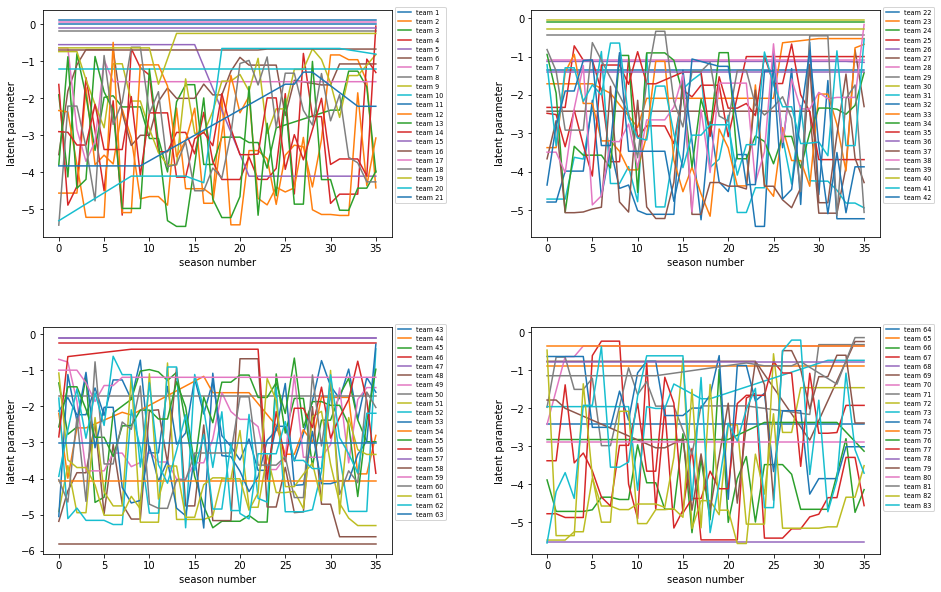

In [28]:
n_group = 4
group_id = np.array_split(range(N), n_group)
fig = plt.figure(figsize = (15,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for g in range(n_group):
    ax = fig.add_subplot(2, 2, g + 1)
    for i in group_id[g]:
        ax.plot(beta[:,i], label="team %d"%(i + 1))
    plt.xlabel("season number")
    plt.ylabel("latent parameter")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1.03, 1, 0),prop={'size': 6.5},ncol = 1)


## Larger Penalty

In [12]:
objective_admm_l1, objective_admm_b_l1, beta_admm_l1 = admm_l1(data = game_matrix_list,l_penalty = 200,
    max_iter = 1000,
    ths = 1e-12,
    eta = 5000,
    step_init = 1,
    max_back = 100,
    a = 0.02,
    b = 0.3,
    verbose = True,
    return_b_obj = True)

initial objective value: 351878.245653
1-th ADMM, objective value: 254094.000770
2-th ADMM, objective value: 260461.228254
Converged!


In [13]:
T, N = game_matrix_list.shape[0:2]
beta = beta_admm_l1.reshape((T,N))

# ascending order
rank = np.argsort(-beta[-1,])

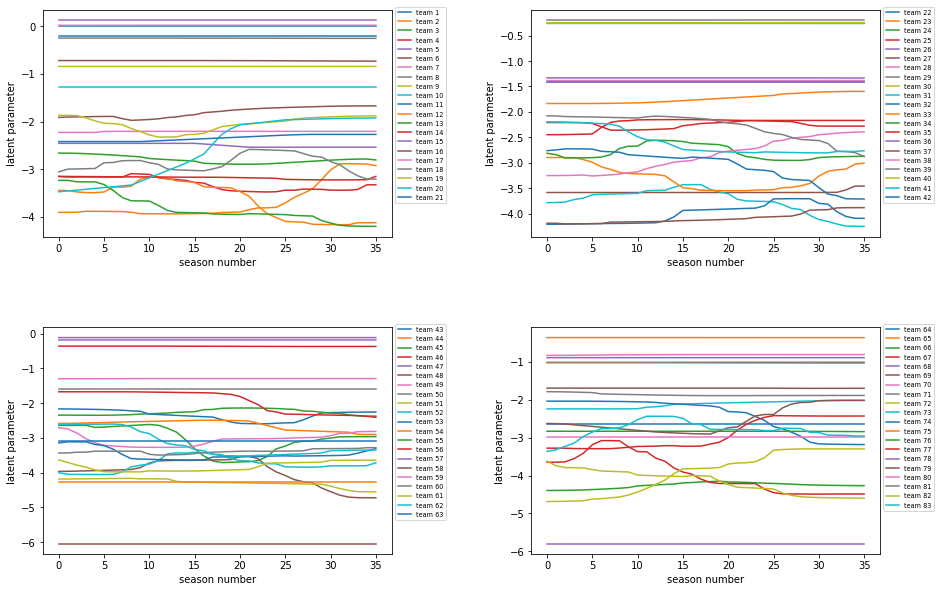

In [14]:
n_group = 4
group_id = np.array_split(range(N), n_group)
fig = plt.figure(figsize = (15,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for g in range(n_group):
    ax = fig.add_subplot(2, 2, g + 1)
    for i in group_id[g]:
        ax.plot(beta[:,i], label="team %d"%(i + 1))
    plt.xlabel("season number")
    plt.ylabel("latent parameter")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1.03, 1, 0),prop={'size': 6.5},ncol = 1)


In [15]:
import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects:
with open('nascar_l1_200.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([objective_admm_l1, objective_admm_b_l1, beta_admm_l1,], f)
#     pickle.dump([objective_nt_l2sq, beta_nt_l2sq], f)
# # Getting back the objects:
# with open('objs.pkl') as f:  # Python 3: open(..., 'rb')
#     obj0, obj1, obj2 = pickle.load(f)